# Identify Clusters using the K-Means Algorithm

## K-Means Algorithm

https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html

# Prepare the Environment

## Upgrade the version of boto3 and sagemaker and Install necessary software

In [51]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [52]:
# Install mxnet

%pip install mxnet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


## Import the usual suspect of packages

In [53]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import boto3

import sagemaker
from sagemaker import KMeans
from sagemaker import get_execution_role
from sagemaker import image_uris
from sagemaker import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

import seaborn as sns

import time
from time import gmtime, strftime

import boto3

import json

import os

import mxnet as mx

import numpy as np

import io
from io import StringIO

from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

## Setup your your Environment Variables

In [54]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
runtime = boto3.client('sagemaker')
sagemaker_client = boto3.Session().client("sagemaker")
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::231015462399:role/LabRole
The session is  <sagemaker.session.Session object at 0x7f7c4c433df0>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-231015462399


## Explore the Data

In [55]:
# Read in the Data

sales_data = pd.read_csv('sales.csv')
sales_data.head()

,Customer ID,Age,Sales ($)
0,10001,28,69870
1,10002,32,90187
2,10003,29,60993
3,10004,31,59939
4,10005,39,150107


Text(0, 0.5, 'Sales ($)')

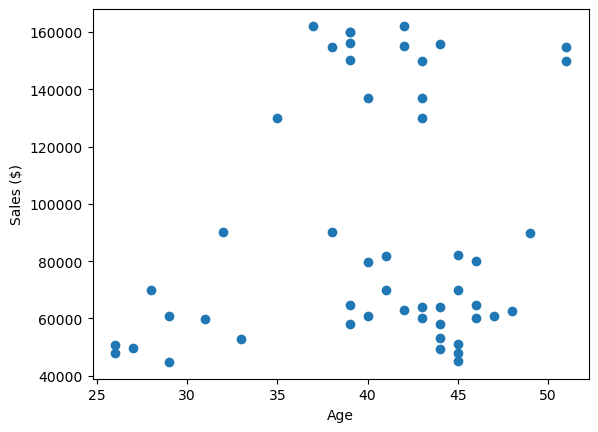

In [56]:
# Graph the Data on a scatter plot

plt.scatter(sales_data['Age'],sales_data['Sales ($)'])
plt.xlabel('Age')
plt.ylabel('Sales ($)')

## Scale the Data
### This is not always necessary if you data is similar in scale

### This is the data before scaling 

In [57]:
sales_data.head()

,Customer ID,Age,Sales ($)
0,10001,28,69870
1,10002,32,90187
2,10003,29,60993
3,10004,31,59939
4,10005,39,150107


### Scale the Data

In [58]:
scaler = MinMaxScaler()

scaler.fit(sales_data[['Sales ($)']])
sales_data['Sales ($)'] = scaler.transform(sales_data[['Sales ($)']])

scaler.fit(sales_data[['Age']])
sales_data['Age'] = scaler.transform(sales_data[['Age']])

### This is the data after scaling 

In [59]:
sales_data.head()

,Customer ID,Age,Sales ($)
0,10001,0.08,0.213426
1,10002,0.24,0.386678
2,10003,0.12,0.137727
3,10004,0.20,0.128739
4,10005,0.52,0.897645


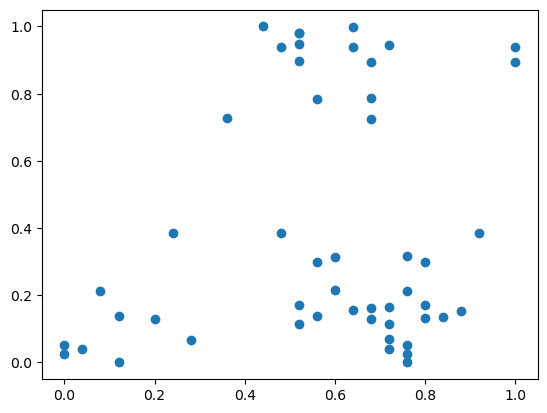

In [60]:
# Plot the data again after being scalled and you notice there is no change

plt.scatter(sales_data.Age,sales_data['Sales ($)'])

## Drop un-necessary data

In [61]:
# Drop the cusotmer ID column since it is not part of the cluster data

sales_data_kmeans = sales_data.drop('Customer ID', axis=1)

In [62]:
sales_data_kmeans.head()

,Age,Sales ($)
0,0.08,0.213426
1,0.24,0.386678
2,0.12,0.137727
3,0.20,0.128739
4,0.52,0.897645


# Data Preparation

In [63]:
# Shuffle and Split the data into 80% training and 20% validating

train_data, test_data = train_test_split(sales_data_kmeans, test_size=0.2)

# Convert dataframes to back to CSV files and save them locally to the notebook and make sure to exclude the headers so that KMeans will accept the file

train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [64]:
# Copy the file to your S3 bucket using sess.upload_data
# You will need to pass the file to be uploaded, a prefix (top level folder to store the data) and the subfolders
# Here we will also define the output folder for the results

prefix = 'Sales'
training_data_path = sess.upload_data( path='train.csv', key_prefix=prefix + '/input/train') 
testing_data_path = sess.upload_data( path='test.csv', key_prefix=prefix + '/input/test')
output_data_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_data_path)
print(testing_data_path)
print(output_data_path)

s3://sagemaker-us-east-1-231015462399/Sales/input/train/train.csv
s3://sagemaker-us-east-1-231015462399/Sales/input/test/test.csv
s3://sagemaker-us-east-1-231015462399/Sales/output


In [65]:
# Creating a channel from the S3 data source and file system
# TrainingInput documentation https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html

training_data_channel = TrainingInput( s3_data=training_data_path, content_type='text/csv') 
testing_data_channel = TrainingInput( s3_data=testing_data_path,   content_type='text/csv')

# Train the Model with different versions of K and plot the SSEs in an elbow plot to Determine K

In [66]:
# gets the K-Means docker image from AWS
image = get_image_uri(boto3.Session().region_name, 'kmeans')

data_location = training_data_path
output_location = output_data_path
test_location = testing_data_path

output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'kmeans-k-discovery-' + output_time
K = range(2, 12) # change the range to be used for k
INSTANCE_COUNT = 2
run_parallel_jobs = True 

job_names = []

# launching jobs for all k
for k in K:
    print('starting train job:' + str(k))
    output_location = 's3://{}/Sales/kmeans-k-discovery/output/'.format(bucket) + output_folder
    print('training artifacts will be uploaded to: {}'.format(output_location))
    job_name = output_folder + str(k)

    create_training_params = \
    {
        "AlgorithmSpecification": {
            "TrainingImage": image,
            "TrainingInputMode": "File"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": output_location
        },
        "ResourceConfig": {
            "InstanceCount": INSTANCE_COUNT,
            "InstanceType": "ml.m4.xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": job_name,
        "HyperParameters": {
            "k": str(k),
            "feature_dim": "2",  # change to the correct number of features
            "mini_batch_size": "1000"
        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 60 * 60
        },
                'InputDataConfig': [
            {
                'ChannelName': 'train',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': data_location,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'text/csv;label_size=0'
            },
            
            {
                'ChannelName': 'test',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': test_location,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'text/csv;label_size=0'
            },
        ]
    }

    sagemaker = boto3.client('sagemaker')

    sagemaker.create_training_job(**create_training_params)

    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


starting train job:2
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462399/Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-14-09-10
InProgress
starting train job:3
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462399/Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-14-09-10
InProgress
starting train job:4
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462399/Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-14-09-10
InProgress
starting train job:5
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462399/Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-14-09-10
InProgress
starting train job:6
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462399/Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-14-09-10
InProgress
starting train job:7
training artifacts will be uploaded to: s3://sagemaker-us-east-1-231015462

In [19]:
# Collect the name of each of the jobs

while len(job_names):
    try:
        sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_names[0])
    finally:
        status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        print("Training job ended with status: " + status)
        if status == 'Failed':
            message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
            print('Training failed with the following error: {}'.format(message))
            raise Exception('Training job failed')

    info = sagemaker.describe_training_job(TrainingJobName=job_name)
    job_names.pop(0)

## Plot your elbow graph to determine the right value of K

Model for k=2 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-532/output/model.tar.gz)
model_algo-1
Model for k=3 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-533/output/model.tar.gz)
model_algo-1
Model for k=4 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-534/output/model.tar.gz)
model_algo-1
Model for k=5 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-535/output/model.tar.gz)
model_algo-1
Model for k=6 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-536/output/model.tar.gz)
model_algo-1
Model for k=7 (Sales/kmeans-k-discovery/output/kmeans-k-discovery-2023-03-20-12-39-53/kmeans-k-discovery-2023-03-20-12-39-537/output/model.tar.gz)
model_algo-1
Model for k=8 (Sales/kmeans-k-discovery/

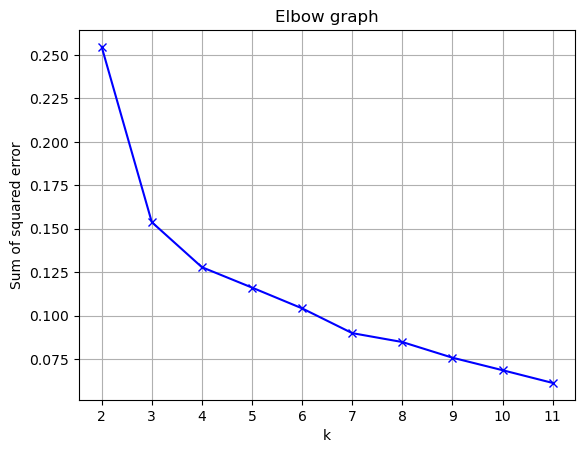

In [20]:
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
for k in K:
    s3_client = boto3.client('s3')
    key = 'Sales/kmeans-k-discovery/output/' + output_folder +'/' + output_folder + str(k) + '/output/model.tar.gz'
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(train_data, kmeans_numpy, 'euclidean'), axis=1)) / train_data.shape[0])
    models[k] = kmeans_numpy
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared error')
plt.title('Elbow graph')
x_labels = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
plt.xticks(ticks=x_labels, labels=x_labels)
plt.grid()
plt.show()

## Start the hyperparameter tunning job

In [21]:
# Enter your value for K that you will use for the hyperparameter tuning job

k = "3"

In [22]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/k-means-tuning.html

tuning_job_name = "sales-data" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())


data_location = training_data_path
output_location = output_data_path
test_location = testing_data_path

sagemaker = boto3.client('sagemaker')

response = sagemaker.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName= tuning_job_name,
    HyperParameterTuningJobConfig={
        'Strategy': 'Bayesian',
        'HyperParameterTuningJobObjective': {
            'Type': 'Minimize',
            'MetricName': 'test:ssd'
        },
        'ResourceLimits': {
            'MaxNumberOfTrainingJobs': 10,
            'MaxParallelTrainingJobs': 2
        },
        'ParameterRanges': {
            'IntegerParameterRanges': [
                {
                    'Name': 'mini_batch_size',
                    'MinValue': '3000',
                    'MaxValue': '15000'
                },
            ],
            'CategoricalParameterRanges': [
                {
                    'Name': 'init_method',
                    'Values': [
                        'kmeans++', 'random'
                    ]
                },
            ]
        },
        'TrainingJobEarlyStoppingType' : 'Auto'
    },
    TrainingJobDefinition={
        'StaticHyperParameters': {
            'k': k,
            'feature_dim': '2', #CHANGE TO MATCH YOUR NUMBER OF FEATURES
        },
        'AlgorithmSpecification': {
            'TrainingImage': image,
            'TrainingInputMode': 'File'
        },
        'RoleArn': role,
        'InputDataConfig': [
            {
                'ChannelName': 'train',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': data_location,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'text/csv;label_size=0'
            },
            
            {
                'ChannelName': 'test',
                'DataSource': {
                    'S3DataSource': {
                        'S3DataType': 'S3Prefix',
                        'S3Uri': test_location,
                        'S3DataDistributionType': 'FullyReplicated'
                    }
                },
                'ContentType': 'text/csv;label_size=0'
            },
        ],
        'OutputDataConfig': {
                'S3OutputPath': output_location
        },
        'ResourceConfig': {
            'InstanceType': 'ml.m5.xlarge',
            'InstanceCount': 1,
            'VolumeSizeInGB': 50
        },
        'StoppingCondition': {
            'MaxRuntimeInSeconds': 60 * 60
        }
    }
)


tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]

while status != "Completed":
    tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
    )
    status = tuning_job_result["HyperParameterTuningJobStatus"]
    print(status)

    job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
    print("Number of jobs completed", job_count)
    
    time.sleep(60)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]


InProgress
Number of jobs completed 0
InProgress
Number of jobs completed 0
InProgress
Number of jobs completed 0
InProgress
Number of jobs completed 0
InProgress
Number of jobs completed 4
InProgress
Number of jobs completed 6
InProgress
Number of jobs completed 9
Completed
Number of jobs completed 10


In [23]:
# Grab the details from each job https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html

tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]

while status != "Completed":
    tuning_job_result = sagemaker.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
    )
    status = tuning_job_result["HyperParameterTuningJobStatus"]
    print(status)

    job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
    print("Number of jobs completed", job_count)
    
    time.sleep(60)

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

In [28]:
# Print out the jobs sorted by the lowest SSE "FinalObjectiveValue"

import sagemaker

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 10
{'lowest': 0.2580701410770416, 'highest': 1.0630403757095337}


,init_method,mini_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,random,3324.0,sales-data2023-03-20-12-51-50-006-7c81d40c,Completed,0.258070,2023-03-20 12:55:56+00:00,2023-03-20 12:56:23+00:00,27.0
2,random,3000.0,sales-data2023-03-20-12-51-50-008-0d236944,Completed,0.260610,2023-03-20 12:56:39+00:00,2023-03-20 12:57:06+00:00,27.0
0,random,3068.0,sales-data2023-03-20-12-51-50-010-1392975f,Completed,0.285702,2023-03-20 12:57:21+00:00,2023-03-20 12:57:48+00:00,27.0
3,random,3491.0,sales-data2023-03-20-12-51-50-007-d04b77c0,Completed,0.292865,2023-03-20 12:56:33+00:00,2023-03-20 12:57:00+00:00,27.0
8,random,12973.0,sales-data2023-03-20-12-51-50-002-94aab4eb,Completed,0.306270,2023-03-20 12:52:58+00:00,2023-03-20 12:54:45+00:00,107.0
1,random,3001.0,sales-data2023-03-20-12-51-50-009-c554282a,Completed,0.306283,2023-03-20 12:57:13+00:00,2023-03-20 12:57:40+00:00,27.0
5,kmeans++,5968.0,sales-data2023-03-20-12-51-50-005-6d830abc,Completed,1.063040,2023-03-20 12:55:53+00:00,2023-03-20 12:56:20+00:00,27.0
6,kmeans++,7082.0,sales-data2023-03-20-12-51-50-004-4d1b7c82,Completed,1.063040,2023-03-20 12:55:16+00:00,2023-03-20 12:55:43+00:00,27.0
7,kmeans++,10307.0,sales-data2023-03-20-12-51-50-003-44e27ae1,Completed,1.063040,2023-03-20 12:55:16+00:00,2023-03-20 12:55:42+00:00,26.0
9,kmeans++,7873.0,sales-data2023-03-20-12-51-50-001-756870f8,Completed,1.063040,2023-03-20 12:52:55+00:00,2023-03-20 12:54:42+00:00,107.0


In [29]:
# Store the best tuning job

job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]

## Make Inferences

### Deploy the Model

In [ ]:
sagemaker = boto3.client('sagemaker')

model_name = job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]

primary_container = {"Image": image, "ModelDataUrl": model_data}

create_model_response = sagemaker.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

### Deploy the Endpoint Config

In [ ]:
endpoint_config_name = "Sales-Data-epc-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = runtime.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

### Deploy the Endpoint

In [32]:
endpoint_name = "Sales-Data-ep-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = runtime.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = runtime.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

try:
    runtime.get_waiter("endpoint_in_service").wait(EndpointName=endpoint_name)
finally:
    resp = runtime.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Arn: " + resp["EndpointArn"])
    print("Create endpoint ended with status: " + status)

    if status != "InService":
        message = runtime.describe_endpoint(EndpointName=endpoint_name)["FailureReason"]
        print("Training failed with the following error: {}".format(message))
        raise Exception("Endpoint creation did not succeed")

Sales-Data-ep-2023-03-20-13-10-42
arn:aws:sagemaker:us-east-1:231015462399:endpoint/sales-data-ep-2023-03-20-13-10-42
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:231015462399:endpoint/sales-data-ep-2023-03-20-13-10-42
Create endpoint ended with status: InService


## Demo how to do infernences

### Single Inference

In [33]:
runtime = boto3.Session().client('sagemaker-runtime',use_ssl=True)
payload = "39,156010"

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read())
print(result)

{'predictions': [{'closest_cluster': 1.0, 'distance_to_cluster': 156009.125}]}


### Batch Inferences

In [34]:
# This where you can plot out the training set or batch load a new dataset

csv_file = io.StringIO()

sales_data_kmeans.to_csv(csv_file, sep=",", header=False, index=False)
payload = csv_file.getvalue()

In [35]:
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body= payload,
    ContentType = 'text/csv')
result = json.loads(response["Body"].read().decode())
clusters = [p["closest_cluster"] for p in result["predictions"]]


In [36]:
print(clusters)

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0]


In [37]:
sales_data['cluster']=clusters
sales_data.head()

,Customer ID,Age,Sales ($),cluster
0,10001,0.08,0.213426,0.0
1,10002,0.24,0.386678,0.0
2,10003,0.12,0.137727,0.0
3,10004,0.20,0.128739,0.0
4,10005,0.52,0.897645,1.0


In [38]:
sales_data.dtypes

Customer ID      int64
Age            float64
Sales ($)      float64
cluster        float64
dtype: object

In [39]:
sales_data['cluster'] = sales_data['cluster'].astype(int)

In [40]:
sales_data.head()

,Customer ID,Age,Sales ($),cluster
0,10001,0.08,0.213426,0
1,10002,0.24,0.386678,0
2,10003,0.12,0.137727,0
3,10004,0.20,0.128739,0
4,10005,0.52,0.897645,1


## Get the cluster centroids from the model artifact

In [41]:
key = 'model.tar.gz'
model_path = 'Sales/output/' +tuning_job_result["BestTrainingJob"]["TrainingJobName"] + "/output/" + key
print(bucket)
print(key)
print(model_path)

s3_client = boto3.client('s3')
s3_client.download_file(bucket, model_path, 'model.tar.gz')
print("Model for k={} ({})".format(k, key))
!tar -xvf model.tar.gz                       
kmeans_model=mx.ndarray.load('model_algo-1')

sagemaker-us-east-1-231015462399
model.tar.gz
Sales/output/sales-data2023-03-20-12-51-50-006-7c81d40c/output/model.tar.gz
Model for k=3 (model.tar.gz)
model_algo-1


In [42]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())

In [43]:
cluster_centroids

,0,1
0,0.117500,0.120515
1,0.615714,0.888640
2,0.700000,0.186997


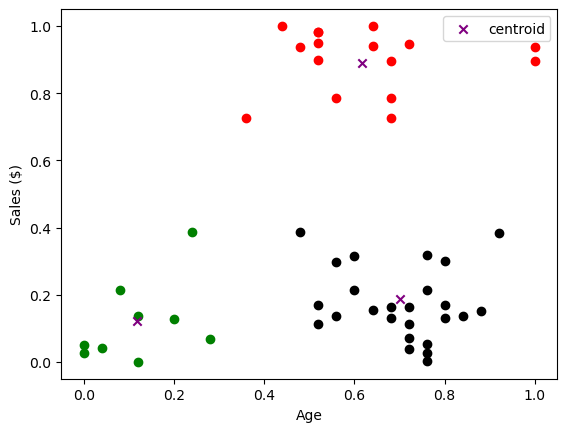

In [44]:
sales_data0 = sales_data[sales_data.cluster==0]
sales_data1 = sales_data[sales_data.cluster==1]
sales_data2 = sales_data[sales_data.cluster==2]
plt.scatter(sales_data0['Age'],sales_data0['Sales ($)'],color='green')
plt.scatter(sales_data1['Age'],sales_data1['Sales ($)'],color='red')
plt.scatter(sales_data2['Age'],sales_data2['Sales ($)'],color='black')
plt.scatter(cluster_centroids[0],cluster_centroids[1],color='purple',marker="x",label='centroid')
plt.xlabel('Age')
plt.ylabel('Sales ($)')
plt.legend()

## Cleanup

In [ ]:
sagemaker_client.delete_model(ModelName=model_name)

In [ ]:
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

In [ ]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)